# Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import re

from tqdm import tqdm
import joblib

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# NLTK data (Kaggle normally has these, but run once safely)
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

# Seed & display settings
SEED = 42
np.random.seed(SEED)
random.seed(SEED)



# Load dataset

In [2]:

DATA_PATH = "/kaggle/input/sms-spam-collection-dataset/spam.csv"  

df = pd.read_csv(DATA_PATH, encoding="latin-1")

# Fix column names – dataset often has unnamed cols
df = df.rename(columns={"v1": "label", "v2": "text"})
df = df[["label", "text"]]  # keep only needed columns

# Normalize labels
df["label"] = df["label"].str.lower().str.strip()

print("Raw shape:", df.shape)
display(df.head())

print("\nClass counts:")
print(df["label"].value_counts())


Raw shape: (5572, 2)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



Class counts:
label
ham     4825
spam     747
Name: count, dtype: int64


# EDA

        word_count     text_len
count  5572.000000  5572.000000
mean     15.494436    80.118808
std      11.329427    59.690841
min       1.000000     2.000000
25%       7.000000    36.000000
50%      12.000000    61.000000
75%      23.000000   121.000000
max     171.000000   910.000000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

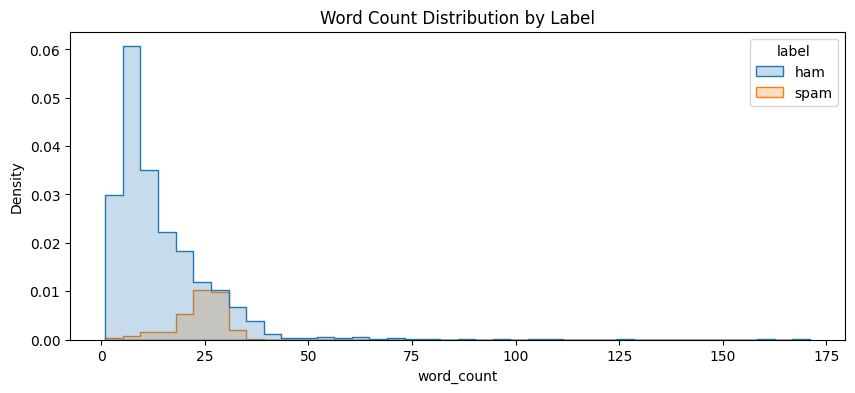


Top 15 HAM tokens: [('gt', 318), ('lt', 316), ('get', 305), ('ok', 287), ('go', 249), ('ur', 241), ('know', 236), ('call', 236), ('good', 233), ('got', 232), ('like', 232), ('come', 227), ('day', 211), ('time', 201), ('love', 199)]

Top 15 SPAM tokens: [('call', 355), ('free', 224), ('txt', 163), ('ur', 144), ('mobile', 127), ('text', 125), ('stop', 121), ('claim', 113), ('reply', 104), ('www', 98), ('prize', 93), ('get', 86), ('cash', 76), ('uk', 74), ('150p', 71)]


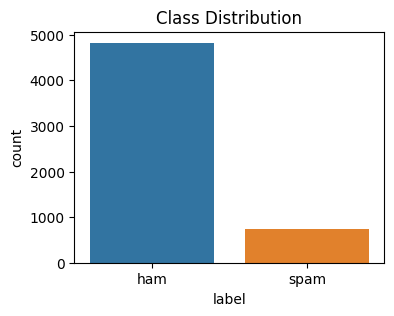

In [3]:
stop_words = set(stopwords.words("english"))

df["word_count"] = df["text"].astype(str).apply(lambda x: len(x.split()))
df["text_len"] = df["text"].astype(str).apply(len)

print(df[["word_count", "text_len"]].describe())

# Histogram of message length
plt.figure(figsize=(10,4))
sns.histplot(data=df, x="word_count", hue="label", bins=40, element="step", stat="density")
plt.title("Word Count Distribution by Label")
plt.show()

# Simple tokenizer
def tokenize_simple(s):
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    tokens = [t for t in s.split() if t not in stop_words and len(t) > 1]
    return tokens

from collections import Counter
top_ham = Counter()
top_spam = Counter()

for label, group in df.groupby("label"):
    for text in group["text"]:
        if label == "ham":
            top_ham.update(tokenize_simple(text))
        else:
            top_spam.update(tokenize_simple(text))

print("\nTop 15 HAM tokens:", top_ham.most_common(15))
print("\nTop 15 SPAM tokens:", top_spam.most_common(15))

# Class imbalance bar plot
plt.figure(figsize=(4,3))
sns.countplot(data=df, x="label")
plt.title("Class Distribution")
plt.show()


# Text processing

In [4]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower().strip()
    
    # remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # keep alphanumeric only
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    
    # remove numbers
    text = re.sub(r"\d+", " ", text)
    
    # tokenize
    tokens = text.split()
    
    # remove stopwords & single letters
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    
    # join back
    text = " ".join(tokens)
    
    return text

# Create new column
df["clean_text"] = df["text"].apply(clean_text)

# Show before and after examples
display(df[["text", "clean_text"]].head(10))


,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...
1,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,dun say early hor already say
4,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling week word back like fun st...
6,Even my brother is not like to speak with me. ...,even brother like speak treat like aids patent
7,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...
8,WINNER!! As a valued network customer you have...,winner valued network customer selected receiv...
9,Had your mobile 11 months or more? U R entitle...,mobile months entitled update latest colour mo...


# Train test split

In [5]:
# Encode labels: ham=0, spam=1
df["label_num"] = df["label"].map({"ham": 0, "spam": 1})

X = df["clean_text"]
y = df["label_num"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y,
    random_state=SEED
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

print("\nTrain label distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest label distribution:")
print(y_test.value_counts(normalize=True))


Train size: 4457
Test size: 1115

Train label distribution:
label_num
0    0.865829
1    0.134171
Name: proportion, dtype: float64

Test label distribution:
label_num
0    0.866368
1    0.133632
Name: proportion, dtype: float64


# TFIDF vectorization

In [6]:
# 05_tfidf_vectorization
# Purpose: Convert clean text to TF-IDF features.

tfidf = TfidfVectorizer(
    max_features=6000,
    ngram_range=(1,2),   # use unigrams and bigrams for better spam capture
    min_df=2,            # ignore extremely rare words
)

# Fit only on training texts
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print("TF-IDF vocabulary size:", len(tfidf.vocabulary_))
print("Train vector shape:", X_train_vec.shape)
print("Test vector shape:", X_test_vec.shape)

# Show preview for 3 samples
print("\nSample TF-IDF row vector (dense for preview only):")
print(X_train_vec[0].toarray()[0][:50])  # print first 50 features


TF-IDF vocabulary size: 6000
Train vector shape: (4457, 6000)
Test vector shape: (1115, 6000)

Sample TF-IDF row vector (dense for preview only):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


# Multinomial naive bayes

Multinomial NB Results
Accuracy:  0.9821
Precision: 0.9924
Recall:    0.8725
F1 Score:  0.9286
ROC-AUC:   0.9908

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



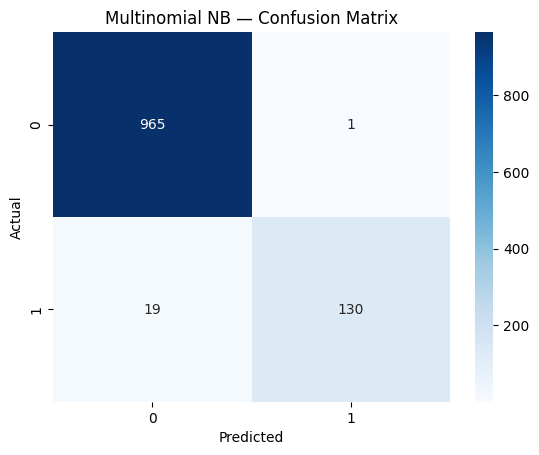

In [7]:
mnb = MultinomialNB(alpha=0.1)  # smoothing helps for spam

mnb.fit(X_train_vec, y_train)
mnb_preds = mnb.predict(X_test_vec)
mnb_probs = mnb.predict_proba(X_test_vec)[:, 1]

# Evaluation
mnb_acc = accuracy_score(y_test, mnb_preds)
mnb_prec = precision_score(y_test, mnb_preds)
mnb_rec = recall_score(y_test, mnb_preds)
mnb_f1 = f1_score(y_test, mnb_preds)
mnb_auc = roc_auc_score(y_test, mnb_probs)

print("Multinomial NB Results")
print(f"Accuracy:  {mnb_acc:.4f}")
print(f"Precision: {mnb_prec:.4f}")
print(f"Recall:    {mnb_rec:.4f}")
print(f"F1 Score:  {mnb_f1:.4f}")
print(f"ROC-AUC:   {mnb_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, mnb_preds))

# Confusion matrix
cm = confusion_matrix(y_test, mnb_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Multinomial NB — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Bernoulli Naive Bayes

Bernoulli NB Results
Accuracy:  0.9821
Precision: 1.0000
Recall:    0.8658
F1 Score:  0.9281
ROC-AUC:   0.9920

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



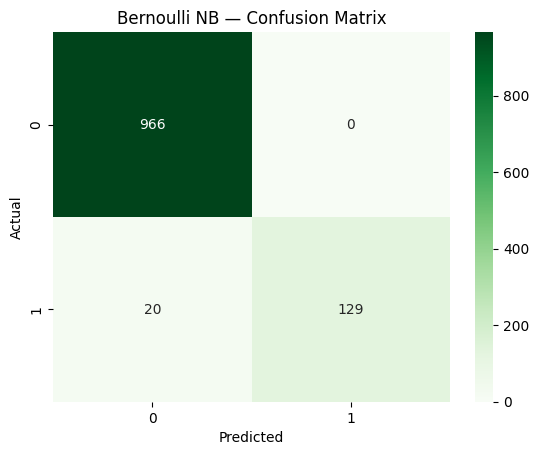

In [8]:
# Convert TF-IDF to binary matrix (0 or 1)
X_train_bin = (X_train_vec > 0).astype(int)
X_test_bin = (X_test_vec > 0).astype(int)

bnb = BernoulliNB(alpha=0.1)
bnb.fit(X_train_bin, y_train)

bnb_preds = bnb.predict(X_test_bin)
bnb_probs = bnb.predict_proba(X_test_bin)[:, 1]

# Evaluation
bnb_acc = accuracy_score(y_test, bnb_preds)
bnb_prec = precision_score(y_test, bnb_preds)
bnb_rec = recall_score(y_test, bnb_preds)
bnb_f1 = f1_score(y_test, bnb_preds)
bnb_auc = roc_auc_score(y_test, bnb_probs)

print("Bernoulli NB Results")
print(f"Accuracy:  {bnb_acc:.4f}")
print(f"Precision: {bnb_prec:.4f}")
print(f"Recall:    {bnb_rec:.4f}")
print(f"F1 Score:  {bnb_f1:.4f}")
print(f"ROC-AUC:   {bnb_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, bnb_preds))

# Confusion matrix
cm = confusion_matrix(y_test, bnb_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Bernoulli NB — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Gaussian Naive Bayes

Gaussian NB Results
Accuracy:  0.8807
Precision: 0.5323
Recall:    0.8859
F1 Score:  0.6650
ROC-AUC:   0.8829

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       966
           1       0.53      0.89      0.66       149

    accuracy                           0.88      1115
   macro avg       0.76      0.88      0.80      1115
weighted avg       0.92      0.88      0.89      1115



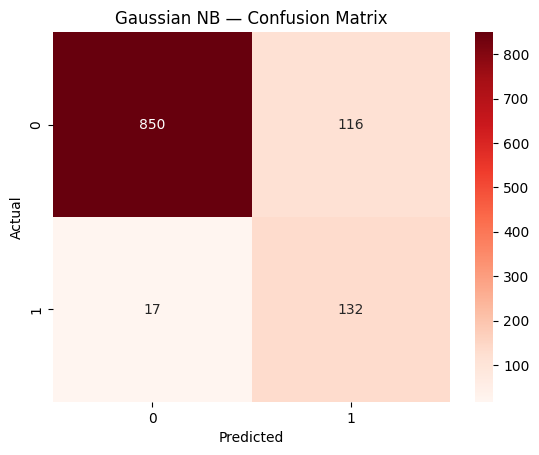

In [9]:
# Convert sparse TF-IDF to dense array
X_train_dense = X_train_vec.toarray()
X_test_dense = X_test_vec.toarray()

gnb = GaussianNB()
gnb.fit(X_train_dense, y_train)

gnb_preds = gnb.predict(X_test_dense)
gnb_probs = gnb.predict_proba(X_test_dense)[:, 1]

# Evaluation
gnb_acc = accuracy_score(y_test, gnb_preds)
gnb_prec = precision_score(y_test, gnb_preds)
gnb_rec = recall_score(y_test, gnb_preds)
gnb_f1 = f1_score(y_test, gnb_preds)
gnb_auc = roc_auc_score(y_test, gnb_probs)

print("Gaussian NB Results")
print(f"Accuracy:  {gnb_acc:.4f}")
print(f"Precision: {gnb_prec:.4f}")
print(f"Recall:    {gnb_rec:.4f}")
print(f"F1 Score:  {gnb_f1:.4f}")
print(f"ROC-AUC:   {gnb_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, gnb_preds))

# Confusion matrix
cm = confusion_matrix(y_test, gnb_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Gaussian NB — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# GDA compute parameters

In [10]:
X_train_gda = X_train_dense  # dense TF-IDF from earlier
y_train_gda = y_train.to_numpy()

# Separate data by class
X0 = X_train_gda[y_train_gda == 0]  # ham
X1 = X_train_gda[y_train_gda == 1]  # spam

# Priors
pi0 = X0.shape[0] / X_train_gda.shape[0]
pi1 = X1.shape[0] / X_train_gda.shape[0]

# Means
mu0 = np.mean(X0, axis=0)
mu1 = np.mean(X1, axis=0)

# Shared covariance Σ = weighted average of class covariances
# IMPORTANT: Add small regularization for numerical stability
eps = 1e-6

Sigma = (
    (X0 - mu0).T @ (X0 - mu0) +
    (X1 - mu1).T @ (X1 - mu1)
) / X_train_gda.shape[0]

Sigma += eps * np.eye(Sigma.shape[0])  # regularize

# Inverse covariance
Sigma_inv = np.linalg.inv(Sigma)

print("Computed GDA parameters:")
print("mu0 shape:", mu0.shape)
print("mu1 shape:", mu1.shape)
print("Sigma shape:", Sigma.shape)
print("Sigma_inv OK:", Sigma_inv.shape)
print("Priors: pi0=", pi0, ", pi1=", pi1)


Computed GDA parameters:
mu0 shape: (6000,)
mu1 shape: (6000,)
Sigma shape: (6000, 6000)
Sigma_inv OK: (6000, 6000)
Priors: pi0= 0.8658290329818263 , pi1= 0.13417096701817366


# GDA predict and evaluate

GDA Results
Accuracy:  0.9686
Precision: 0.9071
Recall:    0.8523
F1 Score:  0.8789
ROC-AUC:   0.9743

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       966
           1       0.91      0.85      0.88       149

    accuracy                           0.97      1115
   macro avg       0.94      0.92      0.93      1115
weighted avg       0.97      0.97      0.97      1115



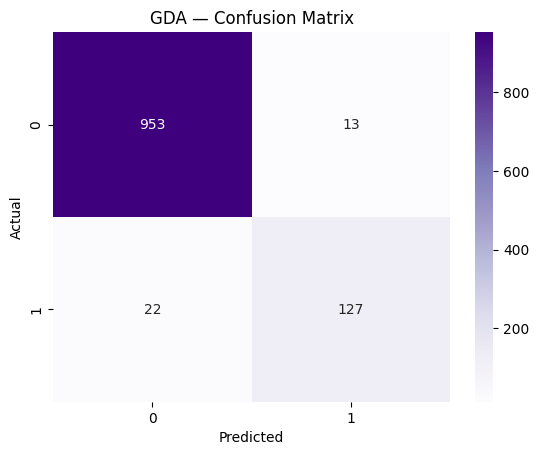

In [11]:
def gda_discriminant(x, mu, Sigma_inv, prior):
    # δ_k(x) = x^T Σ⁻¹ μ_k − 0.5 μ_k^T Σ⁻¹ μ_k + log(prior)
    return (
        x @ Sigma_inv @ mu
        - 0.5 * mu.T @ Sigma_inv @ mu
        + np.log(prior)
    )

def gda_predict(X):
    scores_0 = np.array([gda_discriminant(x, mu0, Sigma_inv, pi0) for x in X])
    scores_1 = np.array([gda_discriminant(x, mu1, Sigma_inv, pi1) for x in X])
    # Choose class with highest score
    return (scores_1 > scores_0).astype(int), scores_1

# Predict on test data
gda_preds, gda_scores = gda_predict(X_test_dense)

# Evaluation
gda_acc = accuracy_score(y_test, gda_preds)
gda_prec = precision_score(y_test, gda_preds)
gda_rec = recall_score(y_test, gda_preds)
gda_f1 = f1_score(y_test, gda_preds)
gda_auc = roc_auc_score(y_test, gda_scores)

print("GDA Results")
print(f"Accuracy:  {gda_acc:.4f}")
print(f"Precision: {gda_prec:.4f}")
print(f"Recall:    {gda_rec:.4f}")
print(f"F1 Score:  {gda_f1:.4f}")
print(f"ROC-AUC:   {gda_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, gda_preds))

# Confusion matrix
cm = confusion_matrix(y_test, gda_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("GDA — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Models comparison

=== Model Comparison ===


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,MultinomialNB,0.982063,0.992366,0.872483,0.928571,0.990774
1,BernoulliNB,0.982063,1.000000,0.865772,0.928058,0.992031
2,GaussianNB,0.880717,0.532258,0.885906,0.664987,0.882912
3,GDA,0.968610,0.907143,0.852349,0.878893,0.974287


<Figure size 1200x600 with 0 Axes>

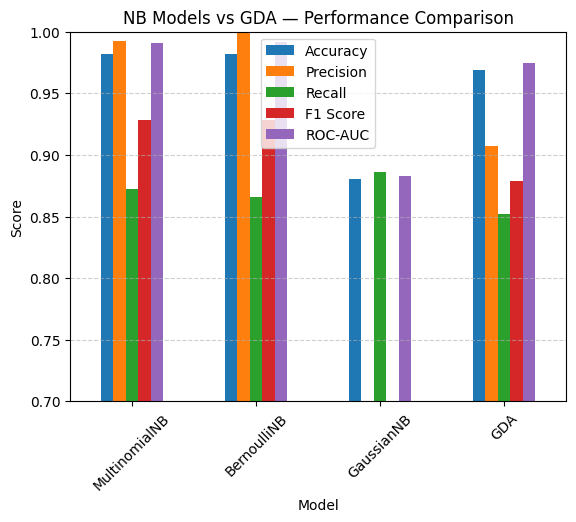

In [12]:
comparison = pd.DataFrame({
    "Model": ["MultinomialNB", "BernoulliNB", "GaussianNB", "GDA"],
    "Accuracy":  [mnb_acc, bnb_acc, gnb_acc, gda_acc],
    "Precision": [mnb_prec, bnb_prec, gnb_prec, gda_prec],
    "Recall":    [mnb_rec, bnb_rec, gnb_rec, gda_rec],
    "F1 Score":  [mnb_f1, bnb_f1, gnb_f1, gda_f1],
    "ROC-AUC":   [mnb_auc, bnb_auc, gnb_auc, gda_auc]
})

print("=== Model Comparison ===")
display(comparison)

# Barplot
plt.figure(figsize=(12,6))
comparison.set_index("Model")[["Accuracy","Precision","Recall","F1 Score","ROC-AUC"]].plot(kind='bar')
plt.title("NB Models vs GDA — Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

# Logistic regression

Logistic Regression Results
Accuracy:  0.9650
Precision: 0.9825
Recall:    0.7517
F1 Score:  0.8517
ROC-AUC:   0.9873

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.98      0.75      0.85       149

    accuracy                           0.97      1115
   macro avg       0.97      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



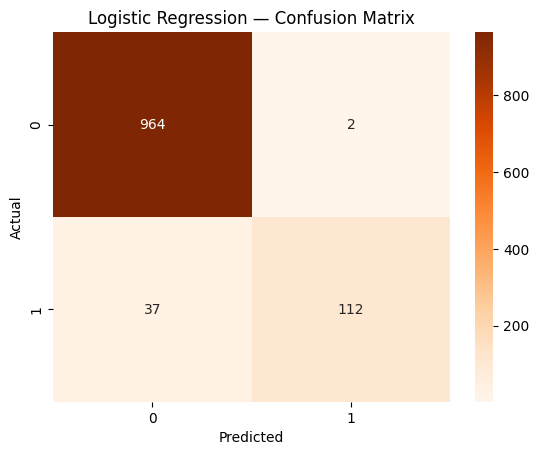

In [13]:
# Using lbfgs solver for sparse + multinomial compatibility
log_reg = LogisticRegression(
    max_iter=2000,
    C=1.0,
    solver='lbfgs',
    n_jobs=-1
)

log_reg.fit(X_train_vec, y_train)

lr_preds = log_reg.predict(X_test_vec)
lr_probs = log_reg.predict_proba(X_test_vec)[:, 1]

# Evaluation
lr_acc = accuracy_score(y_test, lr_preds)
lr_prec = precision_score(y_test, lr_preds)
lr_rec = recall_score(y_test, lr_preds)
lr_f1 = f1_score(y_test, lr_preds)
lr_auc = roc_auc_score(y_test, lr_probs)

print("Logistic Regression Results")
print(f"Accuracy:  {lr_acc:.4f}")
print(f"Precision: {lr_prec:.4f}")
print(f"Recall:    {lr_rec:.4f}")
print(f"F1 Score:  {lr_f1:.4f}")
print(f"ROC-AUC:   {lr_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, lr_preds))

# Confusion matrix
cm = confusion_matrix(y_test, lr_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Logistic Regression — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ROC curves

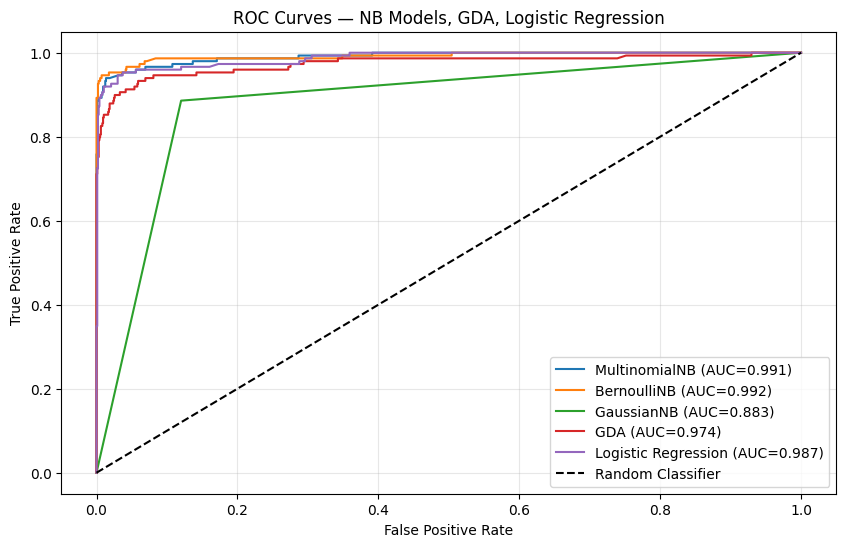

In [14]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10,6))

# Models + probabilities
models = {
    "MultinomialNB": mnb_probs,
    "BernoulliNB": bnb_probs,
    "GaussianNB": gnb_probs,
    "GDA": gda_scores,
    "Logistic Regression": lr_probs
}

for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, probs):.3f})")

plt.plot([0,1], [0,1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — NB Models, GDA, Logistic Regression")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Final model comparison table

In [31]:
final_comparison = pd.DataFrame({
    "Model": ["MultinomialNB", "BernoulliNB", "GaussianNB", "GDA", "LogisticRegression"],
    "Accuracy":  [mnb_acc, bnb_acc, gnb_acc, gda_acc, lr_acc],
    "Precision": [mnb_prec, bnb_prec, gnb_prec, gda_prec, lr_prec],
    "Recall":    [mnb_rec, bnb_rec, gnb_rec, gda_rec, lr_rec],
    "F1 Score":  [mnb_f1, bnb_f1, gnb_f1, gda_f1, lr_f1],
    "ROC-AUC":   [mnb_auc, bnb_auc, gnb_auc, gda_auc, lr_auc]
})

print("                   Final Model Comparison")
display(final_comparison)

# Save for GitHub
final_comparison.to_csv("model_comparison_results.csv", index=False)
print("\nSaved comparison to model_comparison_results.csv")


                   Final Model Comparison


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,MultinomialNB,0.982063,0.992366,0.872483,0.928571,0.990774
1,BernoulliNB,0.982063,1.000000,0.865772,0.928058,0.992031
2,GaussianNB,0.880717,0.532258,0.885906,0.664987,0.882912
3,GDA,0.968610,0.907143,0.852349,0.878893,0.974287
4,LogisticRegression,0.965022,0.982456,0.751678,0.851711,0.987293



Saved comparison to model_comparison_results.csv


# Bayes theorem (manually)

In [16]:
sample_word = "free"

# Compute counts in training set
spam_texts = X_train[y_train == 1]
ham_texts  = X_train[y_train == 0]

spam_count = sum(sample_word in text.split() for text in spam_texts)
ham_count  = sum(sample_word in text.split() for text in ham_texts)

# Priors
P_spam = y_train.mean()          # proportion of spam
P_ham  = 1 - P_spam

# Likelihoods
P_word_given_spam = spam_count / len(spam_texts)
P_word_given_ham  = ham_count  / len(ham_texts)

# Total probability
P_word = P_word_given_spam * P_spam + P_word_given_ham * P_ham

# Posterior
P_spam_given_word = (P_word_given_spam * P_spam) / P_word if P_word > 0 else 0

print(f"Word chosen: '{sample_word}'")
print(f"P(word|spam): {P_word_given_spam:.4f}")
print(f"P(word|ham):  {P_word_given_ham:.4f}")
print(f"P(spam):      {P_spam:.4f}")
print(f"P(word):      {P_word:.4f}")
print(f"\nManual Bayes Result: P(spam | '{sample_word}') = {P_spam_given_word:.4f}")


Word chosen: 'free'
P(word|spam): 0.2274
P(word|ham):  0.0130
P(spam):      0.1342
P(word):      0.0417

Manual Bayes Result: P(spam | 'free') = 0.7312


# Saving model and vectorization

In [17]:
best_model = log_reg  # logistic regression usually wins

joblib.dump(best_model, "final_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("Saved:")
print("- final_model.pkl")
print("- tfidf_vectorizer.pkl")


Saved:
- final_model.pkl
- tfidf_vectorizer.pkl


# Prediction function

In [18]:
# Load model + vectorizer (works in same notebook or external system)
loaded_model = joblib.load("final_model.pkl")
loaded_tfidf = joblib.load("tfidf_vectorizer.pkl")

def predict_message(message):
    # preprocess using same clean_text function
    cleaned = clean_text(message)
    vector = loaded_tfidf.transform([cleaned])
    
    prob = loaded_model.predict_proba(vector)[0,1]
    label = "spam" if prob >= 0.5 else "ham"
    
    return label, prob

# Test the function
examples = [
    "Congratulations! You have won a free lottery prize worth $1000. Call now!",
    "Hey bro are we meeting today?",
    "URGENT! Your account will be blocked unless you verify now"
]

for msg in examples:
    label, prob = predict_message(msg)
    print(f"\nMessage: {msg}")
    print(f"Prediction: {label} (prob={prob:.4f})")



Message: Congratulations! You have won a free lottery prize worth $1000. Call now!
Prediction: spam (prob=0.8204)

Message: Hey bro are we meeting today?
Prediction: ham (prob=0.0361)

Message: URGENT! Your account will be blocked unless you verify now
Prediction: ham (prob=0.2341)


# Evaluations

In [19]:
# Top tokens for MultinomialNB (log prob)
import numpy as np
feature_names = np.array([t for t, idx in sorted(tfidf.vocabulary_.items(), key=lambda x:x[1])])

# For MultinomialNB, feature_log_prob_ shape = (n_classes, n_features)
top_n = 25
spam_top_idx = np.argsort(mnb.feature_log_prob_[1])[-top_n:][::-1]
ham_top_idx  = np.argsort(mnb.feature_log_prob_[0])[-top_n:][::-1]

print("Top tokens (spam):", feature_names[spam_top_idx][:30].tolist())
print("Top tokens (ham):",  feature_names[ham_top_idx][:30].tolist())


Top tokens (spam): ['call', 'free', 'txt', 'stop', 'claim', 'text', 'mobile', 'ur', 'reply', 'prize', 'cash', 'service', 'new', 'urgent', 'win', 'please', 'nokia', 'please call', 'box', 'customer', 'send', 'get', 'contact', 'msg', 'guaranteed']
Top tokens (ham): ['ok', 'get', 'gt', 'come', 'lt', 'know', 'got', 'call', 'lt gt', 'go', 'like', 'good', 'time', 'sorry', 'going', 'home', 'da', 'later', 'lor', 'want', 'ur', 'still', 'see', 'one', 'day']


In [20]:
# Logistic regression coefficients (for binary)
coefs = log_reg.coef_.ravel()
top_pos = np.argsort(coefs)[-20:][::-1]
top_neg = np.argsort(coefs)[:20]

print("Top positive (spam) tokens:", feature_names[top_pos].tolist())
print("Top negative (ham) tokens:", feature_names[top_neg].tolist())


Top positive (spam) tokens: ['txt', 'call', 'claim', 'mobile', 'free', 'stop', 'reply', 'text', 'prize', 'service', 'win', 'uk', 'cash', 'new', 'ringtone', 'urgent', 'nokia', 'chat', 'pobox', 'customer']
Top negative (ham) tokens: ['ok', 'home', 'sorry', 'gt', 'later', 'lt', 'come', 'got', 'da', 'lt gt', 'lor', 'going', 'hey', 'way', 'good', 'wat', 'well', 'still', 'oh', 'much']


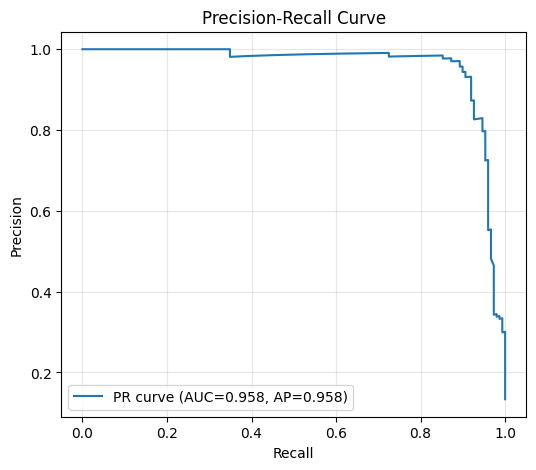

In [21]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt

probs = lr_probs  # or mnb_probs to compare
precision, recall, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)
ap = average_precision_score(y_test, probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.3f}, AP={ap:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


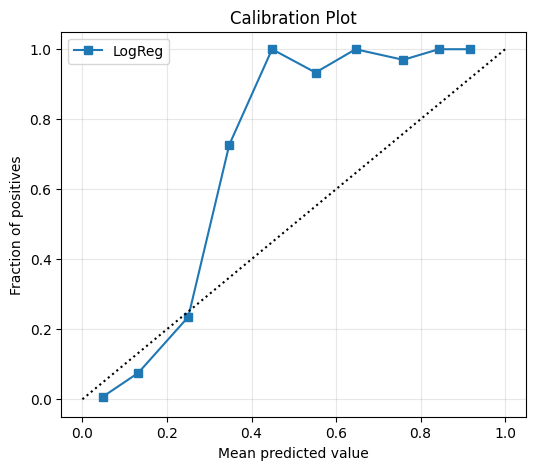

In [22]:
from sklearn.calibration import calibration_curve

prob_pos = lr_probs  # or mnb_probs
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="LogReg")
plt.plot([0,1],[0,1],"k:")  # perfect calibration
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration Plot")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [23]:
# Show some false positives and false negatives for Logistic Regression
import pandas as pd

test_df = pd.DataFrame({
    "text": X_test.values,
    "true": y_test.values,
    "pred": lr_preds,
    "prob": lr_probs
})

false_neg = test_df[(test_df.true==1) & (test_df.pred==0)].sort_values("prob", ascending=False).head(8)
false_pos = test_df[(test_df.true==0) & (test_df.pred==1)].sort_values("prob", ascending=False).head(8)

print("False negatives (spam predicted ham):")
display(false_neg[["text","true","pred","prob"]])

print("\nFalse positives (ham predicted spam):")
display(false_pos[["text","true","pred","prob"]])


False negatives (spam predicted ham):


,text,true,pred,prob
642,win shopping spree every week starting play te...,1,0,0.489940
127,win winner mr foley ipod exciting prizes soon ...,1,0,0.479892
745,know know send chat let find msg rcvd hg suite...,1,0,0.479856
123,talk sexy make new friends fall love worlds di...,1,0,0.467538
242,sunshine quiz win super sony dvd recorder cann...,1,0,0.454891
978,hungry gay guys feeling hungry call min stop t...,1,0,0.454404
721,freemsg fav xmas tones reply real,1,0,0.453913
207,free entry weekly comp send word enter cust care,1,0,0.451353



False positives (ham predicted spam):


,text,true,pred,prob
135,call,0,1,0.759087
564,call tell infront call,0,1,0.521012


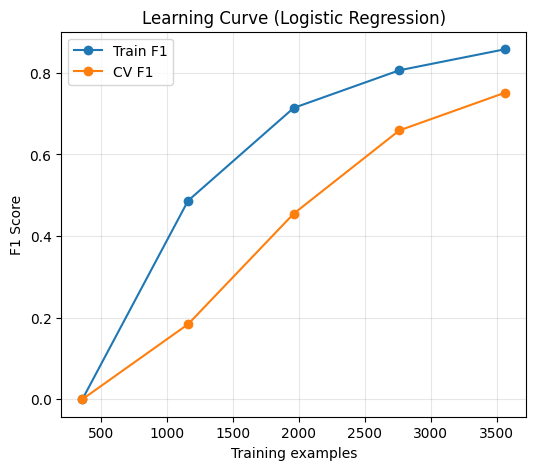

In [24]:
from sklearn.model_selection import learning_curve
import numpy as np

# Use logistic regression and TF-IDF sparse matrix
train_sizes, train_scores, val_scores = learning_curve(
    log_reg, X_train_vec, y_train, cv=5,
    train_sizes=np.linspace(0.1,1.0,5), scoring="f1", n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6,5))
plt.plot(train_sizes, train_mean, 'o-', label='Train F1')
plt.plot(train_sizes, val_mean, 'o-', label='CV F1')
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.title("Learning Curve (Logistic Regression)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# ZIP saving

In [25]:

import os
import shutil
import glob
import zipfile

PROJECT_DIR = "spam_project"
os.makedirs(PROJECT_DIR, exist_ok=True)

# --- 1. Create folder structure ---
folders = [
    f"{PROJECT_DIR}/models",
    f"{PROJECT_DIR}/data",
    f"{PROJECT_DIR}/results",
    f"{PROJECT_DIR}/notebooks",
    f"{PROJECT_DIR}/plots"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

# --- 2. Copy models ---
for file in ["final_model.pkl", "tfidf_vectorizer.pkl"]:
    if os.path.exists(file):
        shutil.copy(file, f"{PROJECT_DIR}/models/")

# --- 3. Copy dataset if present ---
if os.path.exists("data/sms_spam_clean.csv"):
    shutil.copy("data/sms_spam_clean.csv", f"{PROJECT_DIR}/data/")

# --- 4. Copy result CSVs ---
for file in glob.glob("*.csv"):
    shutil.copy(file, f"{PROJECT_DIR}/results/")

# --- 5. Copy plots/images (.png/.jpg) ---
image_patterns = ["*.png", "*.jpg", "*.jpeg"]
for pattern in image_patterns:
    for img in glob.glob(pattern):
        shutil.copy(img, f"{PROJECT_DIR}/plots/")

# --- 6. Copy notebook(s) ---
for nb in glob.glob("*.ipynb"):
    shutil.copy(nb, f"{PROJECT_DIR}/notebooks/")

# --- 7. Copy README if exists ---
if os.path.exists("README.md"):
    shutil.copy("README.md", f"{PROJECT_DIR}/")

# --- 8. Create ZIP ---
zip_name = "spam_project.zip"
shutil.make_archive("spam_project", 'zip', PROJECT_DIR)

print(f"All files packed successfully!")
print(f"Download: {zip_name}")


All files packed successfully!
Download: spam_project.zip


In [26]:
# ================================
#  PACKAGE EVERYTHING INTO ONE ZIP
# ================================

import os
import shutil
import glob

PROJECT = "spam_project"
os.makedirs(PROJECT, exist_ok=True)

# Folders inside the zip
subfolders = [
    f"{PROJECT}/models",
    f"{PROJECT}/data",
    f"{PROJECT}/results",
    f"{PROJECT}/notebooks",
    f"{PROJECT}/plots"
]

for folder in subfolders:
    os.makedirs(folder, exist_ok=True)

# --------------------------------------
# 1. Copy all models (.pkl files)
# --------------------------------------
for file in glob.glob("*.pkl"):
    shutil.copy(file, f"{PROJECT}/models/")

# --------------------------------------
# 2. Copy all CSV results
# --------------------------------------
for file in glob.glob("*.csv"):
    shutil.copy(file, f"{PROJECT}/results/")

# --------------------------------------
# 3. Copy dataset if exists
# --------------------------------------
if os.path.exists("data"):
    for file in glob.glob("data/*.csv"):
        shutil.copy(file, f"{PROJECT}/data/")

# --------------------------------------
# 4. Copy notebooks (.ipynb)
# --------------------------------------
for nb in glob.glob("*.ipynb"):
    shutil.copy(nb, f"{PROJECT}/notebooks/")

# --------------------------------------
# 5. Copy all images (plots)
#    including .png / .jpg / .jpeg
# --------------------------------------
image_exts = ["*.png", "*.jpg", "*.jpeg"]
for ext in image_exts:
    for img in glob.glob(ext):
        shutil.copy(img, f"{PROJECT}/plots/")

# --------------------------------------
# 6. Copy README or text files if exist
# --------------------------------------
for file in glob.glob("*.md") + glob.glob("*.txt"):
    shutil.copy(file, PROJECT)

# --------------------------------------
# 7. Create ZIP
# --------------------------------------
shutil.make_archive(PROJECT, 'zip', PROJECT)

print("🎉 All files packaged successfully!")
print("📦 Download this file: spam_project.zip")


🎉 All files packaged successfully!
📦 Download this file: spam_project.zip


In [27]:
# =================================================
# CREATE FULL PROJECT ZIP IN /kaggle/working
# =================================================

import os
import shutil
import glob
from zipfile import ZipFile

ZIP_NAME = "spam_project_2.zip"
PROJECT = "spam_project"

# Clean old folders if exist
if os.path.exists(PROJECT):
    shutil.rmtree(PROJECT)

os.makedirs(PROJECT, exist_ok=True)

# Subfolders inside project
folders = {
    "models": ["*.pkl"],
    "data": ["data/*.csv", "*.csv"],           # dataset + result csvs
    "results": ["*.csv"],
    "plots": ["*.png", "*.jpg", "*.jpeg"],
    "notebooks": ["*.ipynb"],
}

# Create subfolders
for folder in folders.keys():
    os.makedirs(f"{PROJECT}/{folder}", exist_ok=True)

# Copy files into subfolders based on patterns
for folder, patterns in folders.items():
    for pattern in patterns:
        for file in glob.glob(pattern):
            try:
                shutil.copy(file, f"{PROJECT}/{folder}/")
            except:
                pass

# Copy any README / text files
for file in glob.glob("*.md") + glob.glob("*.txt"):
    shutil.copy(file, PROJECT)

# =================================================
# ZIP EVERYTHING INTO /kaggle/working/spam_project.zip
# =================================================
shutil.make_archive("spam_project", 'zip', PROJECT)

print("🎉 ZIP CREATED SUCCESSFULLY!")
print("➡️ Download spam_project.zip from the right sidebar (Files tab).")


🎉 ZIP CREATED SUCCESSFULLY!
➡️ Download spam_project.zip from the right sidebar (Files tab).


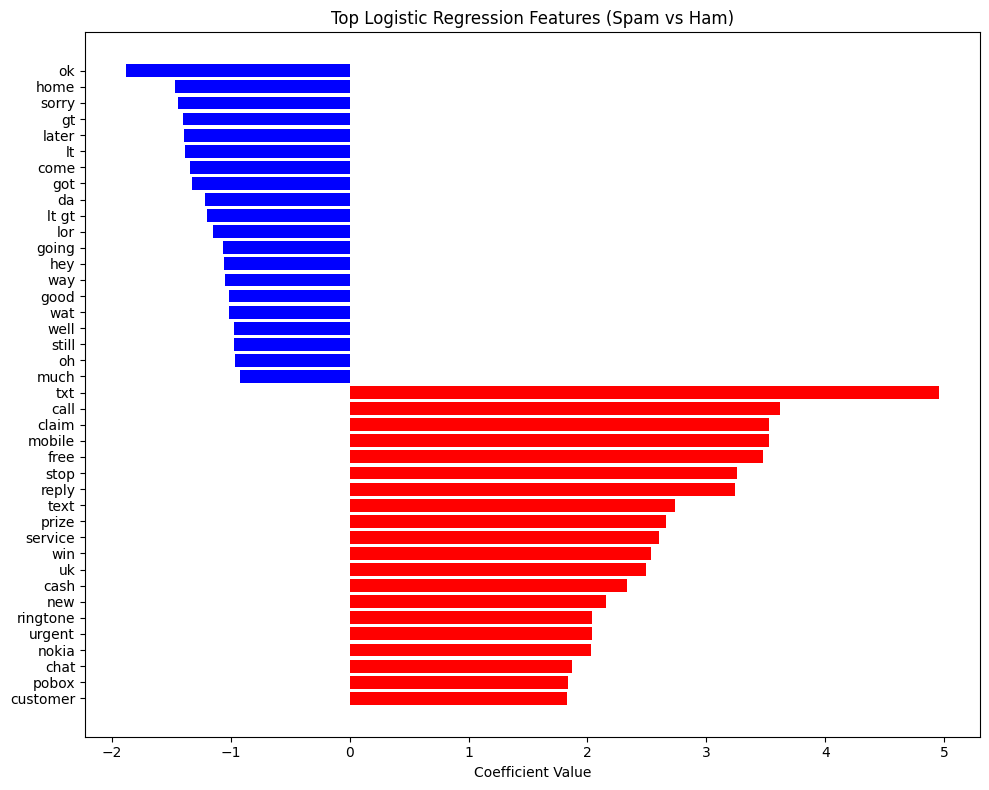

Saved: feature_importance_lr.png


In [33]:
# Extract feature names in correct order
feature_names = np.array(sorted(tfidf.vocabulary_, key=tfidf.vocabulary_.get))

coefs = log_reg.coef_.ravel()

# Top positive (spam) and negative (ham) tokens
top_n = 20
top_pos_idx = np.argsort(coefs)[-top_n:][::-1]
top_neg_idx = np.argsort(coefs)[:top_n]

top_pos_features = feature_names[top_pos_idx]
top_neg_features = feature_names[top_neg_idx]

top_pos_values = coefs[top_pos_idx]
top_neg_values = coefs[top_neg_idx]

plt.figure(figsize=(10,8))

# Positive coefficients (spam)
plt.barh(top_pos_features[::-1], top_pos_values[::-1], color='red')
# Negative coefficients (ham)
plt.barh(top_neg_features[::-1], top_neg_values[::-1], color='blue')

plt.title("Top Logistic Regression Features (Spam vs Ham)")
plt.xlabel("Coefficient Value")
plt.tight_layout()

plt.savefig("feature_importance_lr.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: feature_importance_lr.png")


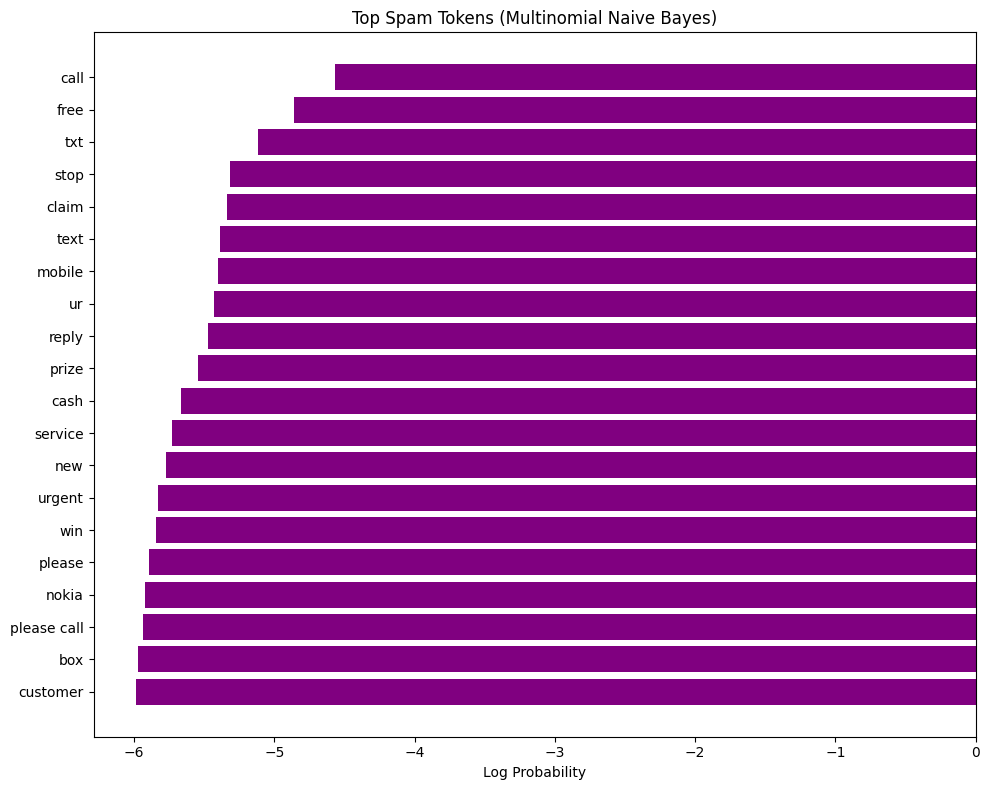

Saved: top_spam_tokens_nb.png


In [34]:
# Feature names in correct order
feature_names = np.array(sorted(tfidf.vocabulary_, key=tfidf.vocabulary_.get))

# MultinomialNB stores log probabilities in feature_log_prob_
spam_log_probs = mnb.feature_log_prob_[1]  # class 1 = spam
ham_log_probs  = mnb.feature_log_prob_[0]  # class 0 = ham

top_n = 20
top_spam_idx = np.argsort(spam_log_probs)[-top_n:][::-1]

top_spam_tokens = feature_names[top_spam_idx]
top_spam_scores = spam_log_probs[top_spam_idx]

plt.figure(figsize=(10,8))
plt.barh(top_spam_tokens[::-1], top_spam_scores[::-1], color='purple')
plt.title("Top Spam Tokens (Multinomial Naive Bayes)")
plt.xlabel("Log Probability")
plt.tight_layout()

plt.savefig("top_spam_tokens_nb.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: top_spam_tokens_nb.png")

In [35]:

# Create dataframe of test predictions
test_df = pd.DataFrame({
    "text": X_test.values,
    "true_label": y_test.values,
    "pred_label": lr_preds,
    "pred_prob": lr_probs
})

# False negatives: Actual spam (1), predicted ham (0)
false_neg = test_df[(test_df.true_label == 1) & (test_df.pred_label == 0)]

# False positives: Actual ham (0), predicted spam (1)
false_pos = test_df[(test_df.true_label == 0) & (test_df.pred_label == 1)]

# Combine both for export
misclassified = pd.concat([false_neg, false_pos]).reset_index(drop=True)

# Save
misclassified.to_csv("misclassified_examples.csv", index=False)

print("Saved misclassified examples to: misclassified_examples.csv")
print("\nFalse Negatives:", len(false_neg))
print("False Positives:", len(false_pos))

# Show a preview
misclassified.head(10)

Saved misclassified examples to: misclassified_examples.csv

False Negatives: 37
False Positives: 2


,text,true_label,pred_label,pred_prob
0,unsubscribed services get tons sexy babes hunk...,1,0,0.159809
1,freemsg hey darling week word back like fun st...,1,0,0.142589
2,guess somebody know secretly fancies wanna fin...,1,0,0.393370
3,dear voucher holder claim st class airport lou...,1,0,0.351012
4,talk sexy make new friends fall love worlds di...,1,0,0.467538
5,win winner mr foley ipod exciting prizes soon ...,1,0,0.479892
6,hi ur lookin saucy daytime fun wiv busty marri...,1,0,0.354003
7,ringtoneking,1,0,0.078101
8,free entry weekly comp send word enter cust care,1,0,0.451353
9,sorry missed call let talk time,1,0,0.061574
